# Encodings

Les algorithmes comme les régressions linéaires ne peuvent prendre en entrée que des variables numériques et non des catégories, de plus ils fonctionnent sensiblement mieux quand les variables numériques sont sur des échelles similaires. Pour passer de la donnée brute à des features exploitables, on utilise des techniques d'**encodage** (*feature encoding*)

Celles ci sont de deux ordres : 

- pour pouvoir transformer des **variables catégorielles** en variables numériques
- pour pouvoir transformer des **variables numériques** 

Et jouent un rôle dans la préparation des données pour les modèles de machine learning, que ce soit dans le nettoyage des données ou dans la création de nouvelles caractéristiques (*feature engineering*) 

Nous allons explorer différents encodings avec un jeu de données synthétiques.

> Pour explorer plus en détail je vous recommande la lecture de [cette ressource](https://scikit-learn.org/stable/modules/preprocessing.html).

## 0. Génération des données et fonctionnement d'un encoder dans scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Nombre d'exemples
n_samples = 500

# Générer les features numériques
np.random.seed(42)
surface = np.random.randint(30, 250, n_samples)       # surface en m²
rooms = np.random.randint(1, 8, n_samples)           # nombre de pièces
age = np.random.randint(0, 100, n_samples)           # âge de la maison
distance_center = np.round(np.random.uniform(0.5, 30, n_samples), 2)  # km au centre-ville

# Générer les features catégorielles
neighborhood = np.random.choice(['A', 'B', 'C'], n_samples)  # type de quartier
house_type = np.random.choice(['Apartment', 'Detached', 'Semi-detached'], n_samples)
garage = np.random.choice(['Yes', 'No'], n_samples)

# Générer la target (prix) avec un peu de bruit
price = (surface * 3000 + rooms * 10000 - age * 500 +
         (neighborhood == 'A') * 20000 +
         (neighborhood == 'B') * 10000 +
         (house_type == 'Detached') * 30000 +
         (garage == 'Yes') * 15000 +
         np.random.normal(0, 10000, n_samples))

# Créer le DataFrame
df = pd.DataFrame({
    'Surface': surface,
    'Rooms': rooms,
    'Age': age,
    'Distance_to_center': distance_center,
    'Neighborhood': neighborhood,
    'House_type': house_type,
    'Garage': garage,
    'Price': price
})

df.head()

,Surface,Rooms,Age,Distance_to_center,Neighborhood,House_type,Garage,Price
0,132,4,9,25.74,C,Apartment,Yes,445859.296999
1,209,4,55,24.99,B,Detached,No,673597.245166
2,122,4,16,12.22,B,Detached,Yes,467805.680555
3,44,5,73,20.21,B,Semi-detached,Yes,163406.497121
4,136,7,16,6.55,A,Semi-detached,Yes,508438.448231


Dans scikit-learn, les encoders sont des classes qui implémentent les méthodes `fit` et `transform`. La méthode `fit` permet d'apprendre les paramètres de l'encoder à partir des données d'entraînement, tandis que la méthode `transform` applique l'encodage aux données.

Un enjeu majeur en machine learning est de ne pas introduire de l'information de l'ensemble de test ou de validation dans l'ensemble d'entraînement (*data leakage*). C'est pourquoi on utilise la méthode `fit` uniquement sur les données d'entraînement, puis on applique la méthode `transform` sur les ensembles de validation et de test.

In [2]:
X, y = df.drop(columns=['Price']), df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 1. Categorical encoding 

Les variables catégorielles sont celles qui ne sont pas des nombres : ce sont des catégories.

Ici nous avons différents cas de figures : les colonnes peuvent avoir deux valeurs (*Garage* : oui/non), plusieurs valeurs ordonnées (*House_type* : apartement/semi-detached/detached) ou plusieurs valeurs non ordonnées (*Neighborhood* : A/B/C).

### 1.1. Variables non ordonnées : `OneHotEncoder`

Pour la colonne `Neighborhood`, les différentes valeurs (A, B ou C) n'ont pas de notion d'ordres intrinsèques. Pour les transformer en valeurs numériques on applique une transformation "one-hot" c'est à dire que l'on crée une colonne par catégorie avec 0 ou 1.

In [3]:
X_train["Neighborhood"].value_counts()

Neighborhood
B    136
A    127
C    112
Name: count, dtype: int64

In [4]:
from sklearn.preprocessing import OneHotEncoder

# instancier l'encodeur
# les parties "output" ne sont pas obligatoires, mais permettent d'obtenir un DataFrame en sortie
enc = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

# fit de l'encodeur sur les données d'entraînement
enc.fit(X_train["Neighborhood"].values.reshape(-1, 1))


OneHotEncoder(sparse_output=False)

Une fois l'encoder fitté, on peut transformer les données de train.

In [5]:
enc.transform(X_train["Neighborhood"].values.reshape(-1, 1))

,x0_A,x0_B,x0_C
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
370,0.0,1.0,0.0
371,1.0,0.0,0.0
372,0.0,1.0,0.0
373,0.0,1.0,0.0


Mais aussi les données de test, sans data leakage ! L'encoder n'a "vu" que les données de train, jamais les données de test.

In [6]:
enc.transform(X_test["Neighborhood"].values.reshape(-1, 1))

,x0_A,x0_B,x0_C
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
120,1.0,0.0,0.0
121,1.0,0.0,0.0
122,0.0,0.0,1.0
123,1.0,0.0,0.0


### 1.2. Le piège du `OneHotEncoder` avec deux catégories

<Axes: xlabel='Garage'>

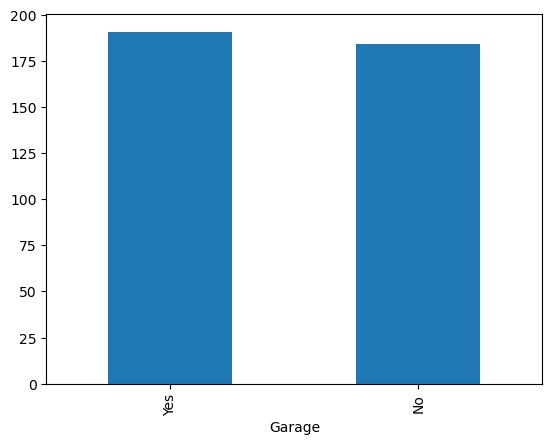

In [7]:
X_train["Garage"].value_counts().plot(kind='bar')

In [8]:
enc = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
enc.fit(X_train["Garage"].values.reshape(-1, 1))

OneHotEncoder(sparse_output=False)

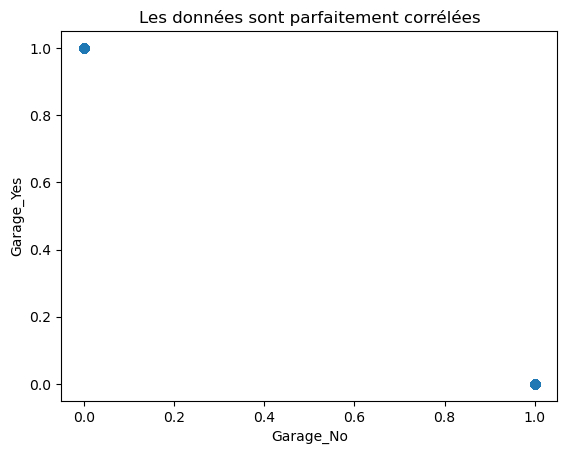

In [9]:
result = enc.transform(X_train["Garage"].values.reshape(-1, 1))

plt.scatter(result.iloc[:, 0], result.iloc[:, 1])
plt.xlabel('Garage_No')
plt.ylabel('Garage_Yes')
plt.title('Les données sont parfaitement corrélées');

Le problème est que les deux variables sont parfaitement corrélées, ce qui va nuire à des algos sensibles à la colinéarité comme les régressions linéaires. 

Pour résoudre ce problème (connu sous le nom de **dummy variable trap**), on supprime une des deux colonnes

In [10]:
enc = OneHotEncoder(sparse_output=False, drop="first").set_output(transform="pandas")

enc.fit_transform(X_train["Garage"].values.reshape(-1, 1))


,x0_Yes
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
370,0.0
371,0.0
372,1.0
373,1.0


### 1.3. `OrdinalEncoder`

Lorsqu'il y a une notion d'ordinalité on utilise cet encoder. Ici c'est le cas pour la colonne `Housetype` : on peut penser qu'un appartement vaut moins qu'une maison indépendante.

In [11]:
X_train["House_type"].unique()

array(['Semi-detached', 'Apartment', 'Detached'], dtype=object)

In [12]:
from sklearn.preprocessing import OrdinalEncoder

# spécifier un ordre pour les catégories
enc = OrdinalEncoder(categories=[['Apartment', 'Semi-detached', 'Detached']]).set_output(transform="pandas")    
enc.fit(X_train["House_type"].values.reshape(-1,1))


OrdinalEncoder(categories=[['Apartment', 'Semi-detached', 'Detached']])

In [13]:
result = enc.transform(X_train["House_type"].values.reshape(-1,1))

pd.concat([X_train["House_type"].reset_index(drop=True), result.rename(columns={0: "House_type_encoded"})], axis=1)

,House_type,x0
0,Semi-detached,1.0
1,Semi-detached,1.0
2,Apartment,0.0
3,Apartment,0.0
4,Semi-detached,1.0
...,...,...
370,Semi-detached,1.0
371,Semi-detached,1.0
372,Semi-detached,1.0
373,Detached,2.0


## 2. Numerical encoding


Vous connaissez déjà les `StandardScaler`, d'autres preprocessors existent : Power Transformer, RobustScaler etc...

Un preprocessor intéressant est le `KBinsDiscretizer` qui "met les valeurs dans des boîtes" i.e. les discrétise / échantillone. 

C'est aussi l'idée derrière le `QuantileTransformer`.

In [14]:
from sklearn.preprocessing import KBinsDiscretizer

enc = KBinsDiscretizer(n_bins=3)

enc.fit(X_train["Age"].values.reshape(-1, 1))

KBinsDiscretizer(n_bins=3)

<Axes: ylabel='Frequency'>

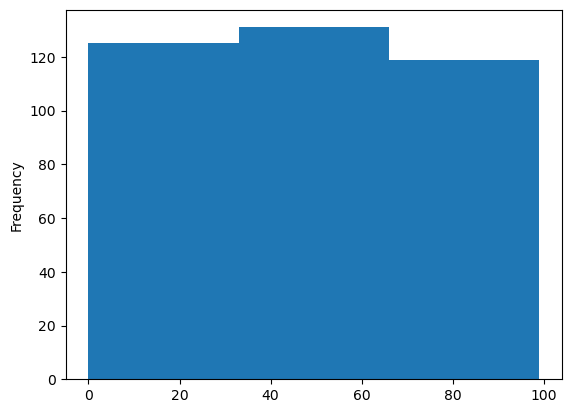

In [15]:
X_train["Age"].plot(kind="hist", bins=3)

Cette idée permet de régulariser nos données e.g. en créant des catégories :

- faible
- moyen 
- fort

## 3. Combiner les encodings dans une pipeline

Pour l'instant, on a appliqué les transformations colonnes par colonnes.

L'object `ColumnTransformer` permet de **combiner toutes les transformations** pour traiter tout notre dataset à la fois :
- il facilite donc largement le preprocessing et permet de **visualiser les transformations** opérées sur le dataset 
  
- tout en **évitant le data leakage** 
  
- et en s'**intégrant au workflow ML** (cross-validation, grid search ...) puisque l'objet retourné possède des méthodes `fit` et `transform`.

Sa syntaxe est la suivante : 

```python 
# instantiation d'un objet de la classe ColumnTransformer
ColumnTransformer(
    transformers=[
        # premier encoder
        ('num',  ## nom de l'encoder dans la pipeline
        StandardScaler(), ## encoder per se
        num_features), ## colonnes auxquelles il s'applique

        # deuxième encoder
        ('cat', ## nom de l'encoder dans la pipeline
        OneHotEncoder(drop='first'), ## encoder per se
        cat_features)## colonnes auxquelles il s'applique

        # etc ..
    ]
)
```

Un intérêt est de pouvoir visualiser les transformations opérées sur notre dataset.

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer


# Colonnes numériques et catégorielles
num_features = ['Surface', 'Rooms', 'Age', 'Distance_to_center']
cat_features = ['Neighborhood', 'House_type', 'Garage']

# Définir le transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Surface', 'Rooms', 'Age',
                                  'Distance_to_center']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Neighborhood', 'House_type', 'Garage'])])

Et on peut l'appliquer pour transformer nos données

In [17]:
preprocessor.fit_transform(X_train)

array([[ 0.75833533, -0.51095396,  1.72347021, ...,  0.        ,
         1.        ,  1.        ],
       [-0.20963078,  1.00173868, -0.8287313 , ...,  0.        ,
         1.        ,  1.        ],
       [-0.32070886, -1.01518484, -1.66781124, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.30484056, -0.00672308,  0.91935193, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.02839367,  0.4975078 ,  1.54866189, ...,  1.        ,
         0.        ,  1.        ],
       [-1.1458603 , -1.51941572,  1.40881523, ...,  0.        ,
         1.        ,  0.        ]])

Cette array numpy n'est pas très explicite ... On peut se faire une meilleure idée de ce qui ressort de notre preprocessing ainsi : 

In [18]:
preprocessor.get_feature_names_out()

array(['num__Surface', 'num__Rooms', 'num__Age',
       'num__Distance_to_center', 'cat__Neighborhood_B',
       'cat__Neighborhood_C', 'cat__House_type_Detached',
       'cat__House_type_Semi-detached', 'cat__Garage_Yes'], dtype=object)

# Exercice : pipeline complète sur ce dataset

- séparer en train et test

- encoding :
  - ordinal sur House type
  - one hot sur les autres
  - Standard Scaler sur les variables numériqeus

- faire une baseline avec un DummyRegressor

- GridSeacher avec un lasso sur l'ensemble de train 

- réentrainer le meilleur modèle sur tout le train 

- regarder la rmse sur l'ensemble de test

### 1. Séparer train et test 

On ne touche plus au test que l'on garde pour l'évaluation finale

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### 2. Créer une pipeline d'encoding

Qui sera "fittée" à chaque entraînement de notre cross validation

In [20]:
# sélection des variables numériques / catégorielles
colonnes_numeriques = X_train.select_dtypes("number").columns.to_list()
colonnes_categorielles = X_train.select_dtypes("object").columns.to_list()

# création du preprocessor : conjonction de plusieurs encoders
preprocessor = ColumnTransformer([
    # premier encoder
    ## nom de l'encoder dans la pipeline
    ("ordinal_house",
    ## objet sklearn associé
    OrdinalEncoder(categories=[['Apartment', 'Semi-detached', 'Detached']]),
    ## colonnes sur lesquelles faire tourner l'encoder
    ["House_type"]), 

    # deuxième encoder
    ## nom de l'encoder dans la pipeline
    ("onehot",
    ## objet sklearn associé
    OneHotEncoder(drop="first"), # pour éviter la colinéarité
    ## colonnes sur lesquelles faire tourner l'encoder
    ## ici toutes les catégorielles sauf house_type
    [c for c in colonnes_categorielles if c != "House_type"]),

    # idem
    ("scaler",
     StandardScaler(),
     colonnes_numeriques)
]
)

preprocessor

ColumnTransformer(transformers=[('ordinal_house',
                                 OrdinalEncoder(categories=[['Apartment',
                                                             'Semi-detached',
                                                             'Detached']]),
                                 ['House_type']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['Neighborhood', 'Garage']),
                                ('scaler', StandardScaler(),
                                 ['Surface', 'Rooms', 'Age',
                                  'Distance_to_center'])])

Pour l'instant, la pipeline n'est pas fittée ...

### 3. Faire une baseline avec un DummyRegressor

Cela nous permettra de voir à quel point notre modèle est bon / meilleur qu'un prédicteur très simple.

In [21]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error as rmse 

# notre estimateur de baseline
# qui prédit systématiquement la moyenne de la colonne SalePrice de 
# l'ensemble d'entraînementu prix de Sale
dummy_baseline = DummyRegressor(strategy="mean")

# pour chaîner le preprocessing et la prédiction
dummy_pipeline = make_pipeline(
    preprocessor, # preprocessing
    dummy_baseline # estimateur
)

dummy_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal_house',
                                                  OrdinalEncoder(categories=[['Apartment',
                                                                              'Semi-detached',
                                                                              'Detached']]),
                                                  ['House_type']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Neighborhood', 'Garage']),
                                                 ('scaler', StandardScaler(),
                                                  ['Surface', 'Rooms', 'Age',
                                                   'Distance_to_center'])])),
                ('dummyregressor', DummyRegressor())])

On peut fitter cette baseline sur l'ensemble d'entraînement en entier (sans cross validation ici).

In [22]:
dummy_pipeline.fit(X_train, y_train)

y_train_pred = dummy_pipeline.predict(X_train)
y_test_pred = dummy_pipeline.predict(X_test)

print("RMSE sur l'ensemble d'entraînement : ",
      rmse(y_train, y_train_pred).round(2))
print("RMSE sur l'ensemble de test : ",
      rmse(y_test, y_test_pred).round(2))

RMSE sur l'ensemble d'entraînement :  192221.75
RMSE sur l'ensemble de test :  195020.37


### 4. Gridsearcher le meilleur hyperparamètre d'un lasso

Pour chaque valeur d'hyperparamètre testé, on cross-valide notre modèle avec un Kfold. 

On retrouve ainsi l'hyperparamètre qui donne la moyenne de rmse la plus basse sur tous les folds : ce sera le meilleur modèle.

In [23]:
from sklearn.linear_model import Lasso 
from sklearn.model_selection import GridSearchCV, KFold

lasso_search = GridSearchCV(
    estimator=make_pipeline(
        preprocessor,
        Lasso()
    ),
    param_grid={
        'lasso__alpha': np.linspace(0.01, 100, 10)
    },
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

lasso_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinal_house',
                                                                         OrdinalEncoder(categories=[['Apartment',
                                                                                                     'Semi-detached',
                                                                                                     'Detached']]),
                                                                         ['House_type']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Neighborhood',
                                                                          'Garage']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Surface',
                                                                          'Rooms',
                                                                          'Age',
                                                                          'Distance_to_center'])])),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.000e-02, 1.112e+01, 2.223e+01, 3.334e+01, 4.445e+01, 5.556e+01,
       6.667e+01, 7.778e+01, 8.889e+01, 1.000e+02])},
             scoring='neg_root_mean_squared_error')

In [24]:
lasso_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinal_house',
                                                                         OrdinalEncoder(categories=[['Apartment',
                                                                                                     'Semi-detached',
                                                                                                     'Detached']]),
                                                                         ['House_type']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Neighborhood',
                                                                          'Garage']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Surface',
                                                                          'Rooms',
                                                                          'Age',
                                                                          'Distance_to_center'])])),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.000e-02, 1.112e+01, 2.223e+01, 3.334e+01, 4.445e+01, 5.556e+01,
       6.667e+01, 7.778e+01, 8.889e+01, 1.000e+02])},
             scoring='neg_root_mean_squared_error')

On peut maintenant chercher le meilleur paramètre

In [25]:
lasso_search.best_params_

{'lasso__alpha': np.float64(44.449999999999996)}

### 5. Réentrainer le meilleur modèle sur l'ensemble du train et l'évaluer sur le test

Une fois qu'on a le meilleur estimateur possible, on utilise toutes nos données pour le réentrainer.

En l'évaluant sur l'ensemble de test, on évalue la véritable capacité de généralisation du modèle sur des nouvelles données.

In [26]:
final_pipeline = make_pipeline(
    preprocessor,
    Lasso(alpha=lasso_search.best_params_['lasso__alpha'])
)

final_pipeline.fit(X_train, y_train)

y_train_pred = final_pipeline.predict(X_train)
y_test_pred = final_pipeline.predict(X_test)

print("RMSE sur l'ensemble d'entraînement : ",
        rmse(y_train, y_train_pred).round(2))
print("RMSE sur l'ensemble de test : ",
        rmse(y_test, y_test_pred).round(2))

RMSE sur l'ensemble d'entraînement :  11743.56
RMSE sur l'ensemble de test :  12104.01


Ici même sur des données synthétiques très simples, la performance a été significativement améliorée !

# A retenir 


- le fonctionnement d'un encoder simple (OneHot, Ordinal, Scalers)
- comment les combiner dans une pipeline acec `ColumnTransformer` pour éviter le *leakage*
- comment les combiner au workflow classique de ml